# all imports

In [1]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rnn_type = nn.LSTM # or nn.GRU

# parameters

In [3]:
# Choose subset of parts to train
keep_parts = slice(10)

epochs = 20 # ctrl-c to stop early
lr = 0.001

seq_len = 26
batch_size = 4 # previous val 2

# Increase hidden_dim depending on number of parts being trained
# since it encodes forecast for all parts
hidden_dim = 512
layers = 2

# How many weeks to forecast
predict_steps = 4
# Forecast starts immediately after this slice of data
predict_input = slice(-predict_steps//2)
print(predict_input)

slice(None, -2, None)


In [4]:
array = pd.read_csv("order-data.csv", skiprows=[0]).to_numpy()[keep_parts]

# test with sin wave

In [5]:
# Uncomment cell to test predicting sin waves to make sure everything is working...
# epochs = 10000
# lr = .001
# seq_len = 150
# batch_size = 1
# hidden_dim = 128
# layers = 2
# predict_steps = 100
# predict_input = slice(-seq_len, None)
# # Sequence needs to see at least a full wave length or results are bad
# array = np.array([[f'Wave {i}']+[np.sin(x + i*2*np.pi/2)*(i+1) for x in np.linspace(-1000, 1000, 10051)] for i in range(2)])

# transpose data
Extract part name from first column.  Transpose data so each column holds the quantities for a part.

In [6]:
part_names = array.T[0]
floats = np.array(array.T[1:], dtype='float32')
floats.shape

(156, 10)

# normalize quantities to be 0 - 1

In [7]:
min_ = floats.min(0)
max_ = floats.max(0)
normalize   = lambda values: (values - min_) / (max_ - min_)
unnormalize = lambda normalized: normalized * (max_ - min_) + min_

tensor = torch.from_numpy(normalize(floats))

# batch data
Notice how the columns line up. The hidden state output from 0,1,2,3,4 gets fed into sequence 5,6,7,8,9

In [8]:
def batch_data(items, seq_len, batch_size):
    num_batches = (len(items)-1) // (seq_len * batch_size)
    keep = num_batches*seq_len*batch_size
    discard = len(items) - keep - 1
    if discard: print(f"Discarding last {discard} items")
    features = items[:keep]   .view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    targets  = items[1:keep+1].view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    return [*zip(features, targets)]

for x, target in batch_data(torch.tensor(range(31)), seq_len=5, batch_size=3):
    print(x[:,:,0])

tensor([[ 0, 10, 20],
        [ 1, 11, 21],
        [ 2, 12, 22],
        [ 3, 13, 23],
        [ 4, 14, 24]])
tensor([[ 5, 15, 25],
        [ 6, 16, 26],
        [ 7, 17, 27],
        [ 8, 18, 28],
        [ 9, 19, 29]])


In [9]:
split = int(tensor.shape[0] * .8)
print(split)
train = batch_data(tensor[:split], seq_len, batch_size)
valid = batch_data(tensor[split:], seq_len=13, batch_size=2)

# Until we get more data...
#train = valid = batch_data(tensor, seq_len, batch_size)

124
Discarding last 19 items
Discarding last 5 items


# create RNN model
Using LSTM but GRU might be better

In [10]:
class RNN(nn.Module):
    def __init__(self, input_dim, dropout=.3):
        super().__init__()
        self.rnn = rnn_type(input_dim, hidden_dim, layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        y, hidden = self.rnn(x, hidden)
        y = y.view(-1, hidden_dim)
        y = self.dropout(y)
        y = self.fc(y)
        return y.view(x.shape), hidden

# define loss and optimizer

In [11]:
model = RNN(tensor.shape[-1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train
Kernal -> Interrupt to end training early

In [12]:
#for epoch in range(epochs):
for epoch in range(150):
    model.train()
    train_loss = 0
    hidden = None
    for x, target in train:
        if hidden is not None:
            if isinstance(hidden, tuple):
                hidden = tuple(h.detach() for h in hidden) # LSTM
            else:
                hidden = hidden.detach() # GRU

        y, hidden = model(x, hidden)
        loss = criterion(y, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        hidden = None
        for x, target in valid:
            y, hidden = model(x, hidden)
            loss = criterion(y, target)
            valid_loss += loss.item()

    print(f"Epoc {epoch}",
          f"train_loss={round(train_loss*1e5/len(train))}",
          f"valid_loss={round(valid_loss*1e5/len(valid))}")

Epoc 0 train_loss=3771 valid_loss=1866
Epoc 1 train_loss=3201 valid_loss=1822
Epoc 2 train_loss=3000 valid_loss=2035
Epoc 3 train_loss=3157 valid_loss=1870
Epoc 4 train_loss=3001 valid_loss=1792
Epoc 5 train_loss=2957 valid_loss=1775
Epoc 6 train_loss=2952 valid_loss=1773
Epoc 7 train_loss=2980 valid_loss=1773
Epoc 8 train_loss=2941 valid_loss=1776
Epoc 9 train_loss=2936 valid_loss=1787
Epoc 10 train_loss=2885 valid_loss=1808
Epoc 11 train_loss=2836 valid_loss=1838
Epoc 12 train_loss=2822 valid_loss=1865
Epoc 13 train_loss=2811 valid_loss=1872
Epoc 14 train_loss=2801 valid_loss=1855
Epoc 15 train_loss=2771 valid_loss=1824
Epoc 16 train_loss=2731 valid_loss=1790
Epoc 17 train_loss=2711 valid_loss=1759
Epoc 18 train_loss=2637 valid_loss=1737
Epoc 19 train_loss=2592 valid_loss=1727
Epoc 20 train_loss=2562 valid_loss=1729
Epoc 21 train_loss=2489 valid_loss=1742
Epoc 22 train_loss=2412 valid_loss=1763
Epoc 23 train_loss=2327 valid_loss=1781
Epoc 24 train_loss=2238 valid_loss=1807
Epoc 25 tr

# run data through model to create hidden state then generate predictions

In [13]:
input = tensor[predict_input]
output = torch.zeros(predict_steps, input.shape[1])
model.eval()
with torch.no_grad():
    x, _ = batch_data(input, len(input)-1, 1)[0]
    y, hidden = model(x, None)
    y = y[-1:, :, :]
    output[0] = y[0, 0, :]
    for i in range(1, predict_steps):
        y, hidden = model(y, hidden)
        output[i] = y[0, 0, :]

# unnormalize data

In [19]:
actual = tensor[predict_input.start:][:len(input) + len(output)]
actual = unnormalize(actual.numpy())
predict = unnormalize(output.cpu().numpy())
predict[:]

array([[ 2.38129854e+00,  5.56957336e+02,  1.00783821e+02,
         1.31020111e+02, -1.61746368e+01, -7.31170807e+01,
         7.02656708e+01,  7.14866459e-01,  7.85803080e+00,
        -2.57761326e+01],
       [ 1.24830036e+01,  4.23118591e+02,  1.03226585e+02,
         2.45753311e+02,  1.65743792e+00, -1.51084900e+02,
         1.05529900e+02,  7.45617092e-01,  3.89341698e+01,
        -2.98802471e+01],
       [ 3.20033646e+01,  4.53842255e+02,  1.90695419e+02,
         4.74309418e+02,  4.37198677e+01, -1.55800598e+02,
         2.45557083e+02,  4.03227687e-01,  1.13661186e+02,
        -1.04543858e+01],
       [ 3.82984695e+01,  4.28507843e+02,  1.71942001e+02,
         4.76267822e+02,  8.01903534e+01, -1.08566963e+02,
         2.81122955e+02,  1.60049295e+00,  1.53356812e+02,
         3.12759094e+01]], dtype=float32)

# generate plots

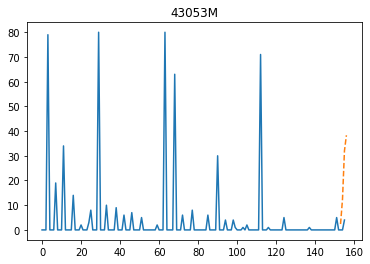

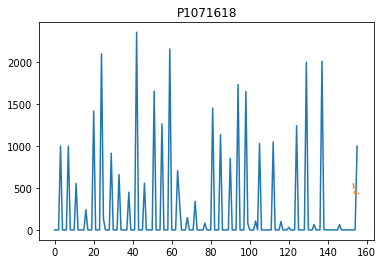

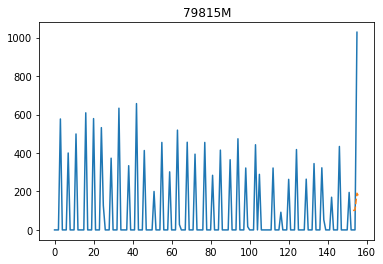

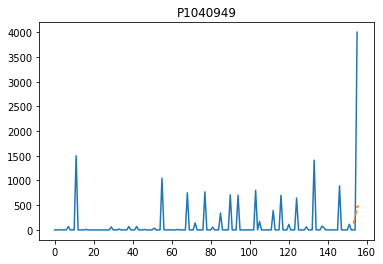

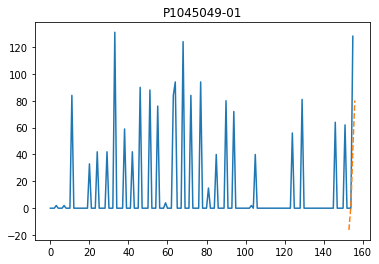

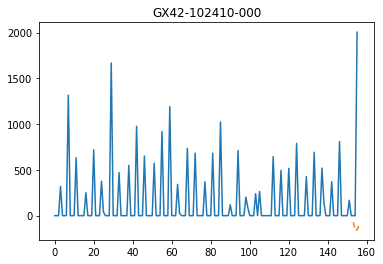

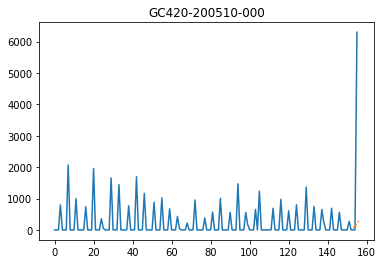

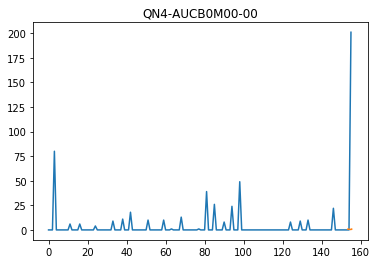

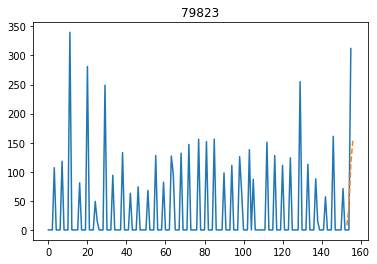

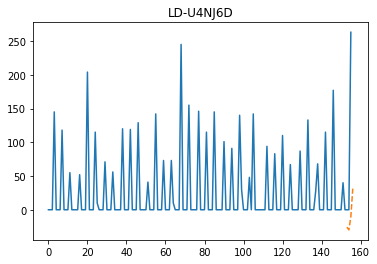

In [15]:
for p in range(actual.shape[1]):
    plt.title(part_names[p])
    plt.plot(range(len(actual)), actual[:, p])
    plt.plot(range(len(x), len(x) + len(predict)), predict[:, p], linestyle='--')
    plt.show()